## 导入库

In [42]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import bz2
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil
import csv
import matplotlib.pyplot as plt

## 下载数据

In [3]:
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    print('Downloading file...')
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('data/wikipedia2text-extracted.txt.bz2', 18377035)

Found and verified data/wikipedia2text-extracted.txt.bz2


## 读取数据

In [6]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""

  with bz2.BZ2File(filename) as f:
    data = []
    file_string = f.read().decode('utf-8')
    file_string = nltk.word_tokenize(file_string)
    data.extend(file_string)
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Data size 11634270
Example words (start):  ['Propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['useless', 'for', 'cultivation', '.', 'and', 'people', 'have', 'sex', 'there', '.']


## 数据预处理并加载数据

In [8]:
def read_data(filename):
  """
  Extract the first file enclosed in a zip file as a list of words
  and pre-processes it using the nltk python library
  """

  with bz2.BZ2File(filename) as f:

    data = []
    file_size = os.stat(filename).st_size
    chunk_size = 1024 * 1024 # reading 1 MB at a time as the dataset is moderately large
    print('Reading data...')
    for i in range(ceil(file_size//chunk_size)+1):
        bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
        file_string = f.read(bytes_to_read).decode('utf-8')
        file_string = file_string.lower()
        # tokenizes a string to words residing in a list
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
  return data

words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Reading data...
Data size 3361041
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


In [11]:
# we restrict our vocabulary size to 50000
vocabulary_size = 50000 

def build_dataset(words):
  count = [['UNK', -1]]
  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
    
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size
    
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 68859], ('the', 226892), (',', 184013), ('.', 120944), ('of', 116323)]
Sample data [1721, 9, 8, 16476, 223, 4, 5166, 4457, 26, 11592]


## skip gram 训练数据生成

In [17]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
  # data_index is updated by 1 everytime we read a data point
  global data_index 
    
  # two numpy arras to hold target words (batch)
  # and context words (labels)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
  # span defines the total window size, where
  # data we consider at an instance looks as follows. 
  # [ skip_window target skip_window ]
  span = 2 * window_size + 1 
    
  # The buffer holds the data contained within the span
  buffer = collections.deque(maxlen=span)
  
  # Fill the buffer and update the data_index
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  # This is the number of context words we sample for a single target word
  num_samples = 2*window_size 

  # We break the batch reading into two for loops
  # The inner for loop fills in the batch and labels with 
  # num_samples data points using data contained withing the span
  # The outper for loop repeat this for batch_size//num_samples times
  # to produce a full batch
  for i in range(batch_size // num_samples):
    k=0
    # avoid the target word itself as a prediction
    # fill in batch and label numpy arrays
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * num_samples + k] = buffer[window_size]
      labels[i * num_samples + k, 0] = buffer[j]
      k += 1 
    
    # Everytime we read num_samples data points,
    # we have created the maximum number of datapoints possible
    # withing a single span, so we need to move the span by 1
    # to create a fresh new span
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']

with window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


## SkipGram算法定义

## 定义超参数


In [18]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

## 定义输入和输出

In [19]:
tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [20]:
# Variables

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Softmax Weights and Biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.5 / math.sqrt(embedding_size))
)
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))

## 定义模型计算

In [21]:
# Model.
# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)

# Compute the softmax loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

## 计算相似度

In [22]:

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [23]:

# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 训练SkipGram

In [35]:
num_steps = 100001
skip_losses = []
# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0

    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):

        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_skip_gram(
            batch_size, window_size)

        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Update the average loss variable
        average_loss += l

        if (step + 1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000

            skip_losses.append(average_loss)
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step + 1, average_loss))
            average_loss = 0

        # Evaluating validation set word similarities
        if (step + 1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    skip_gram_final_embeddings = normalized_embeddings.eval()

# We will save the word vectors learned and the loss over time
# as this information is required later for comparisons
np.save('skip_embeddings', skip_gram_final_embeddings)

with open('skip_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_losses)


Initialized
Average loss at step 2000: 4.009894
Average loss at step 4000: 3.618807
Average loss at step 6000: 3.563971
Average loss at step 8000: 3.453440
Average loss at step 10000: 3.474751
Nearest to by: evinced, hebrews, unlawfully, bochk, wikitable, evangelical, prostaglandins, oilfield,
Nearest to also: carrier-borne, trecento, al-qaeda, академия, arturo, anti-tank, perkins, hot,
Nearest to it: akhtar, prairies, slated, barbizon, harbours, samsung, rostopchin, not,
Nearest to is: was, are, hammon, marlowe, saar, seventies, 3.9, record,
Nearest to ;: kiseru, items, i386, pondered, 1950, 1543, greenbelt, wrongs,
Nearest to for: co-operation, herpete, murray, hurting, in, queens, fluorescence, pebbles,
Nearest to has: affiliates, meucci, bochk, participating, studios, gian, berinthia, thousands,
Nearest to 's: 2.7, noblest, fascist, complaining, hindemith, pancreatitis, components, damaged,
Nearest to not: mcmap, adhd, mourning, outputs, grew, trackways, non-visual, fighting,
Neare

Average loss at step 62000: 3.313563
Average loss at step 64000: 3.318899
Average loss at step 66000: 3.279984
Average loss at step 68000: 3.280675
Average loss at step 70000: 3.295883
Nearest to by: also, that, spirituals, often, pathfinders, ,, scorers, masses,
Nearest to also: by, that, implication, may, these, many, for, this,
Nearest to it: he, this, sni, not, an, considered, that, ott,
Nearest to is: are, has, form, specify, one, dubbing, gliese, a,
Nearest to ;: ., ,, excretion, :, fronted, 2050., alludes, calpurnius,
Nearest to for: of, also, usual, in, tonypandy, as, to, presbyterian,
Nearest to has: have, had, socialists, is, ionization, feline, also, midshipmen,
Nearest to 's: his, her, its, molded, destroyer, spenser, boardman, hyderabad,
Nearest to not: they, only, it, so, n't, but, then, invite,
Nearest to of: ,, in, and, ., to, for, weishan, the,
Nearest to an: a, the, visualize, it, devoted, f-100, another, its,
Nearest to and: ,, of, ., to, the, with, including, or,
Ne

## 可视化 Skip Gram

In [36]:

def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

## t-SNE可视化Embedding

In [37]:
num_points = 1000 # we will use a large sample space to build the T-SNE manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = skip_gram_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')

Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
Out of  1000  samples,  348  samples were selected by pruning


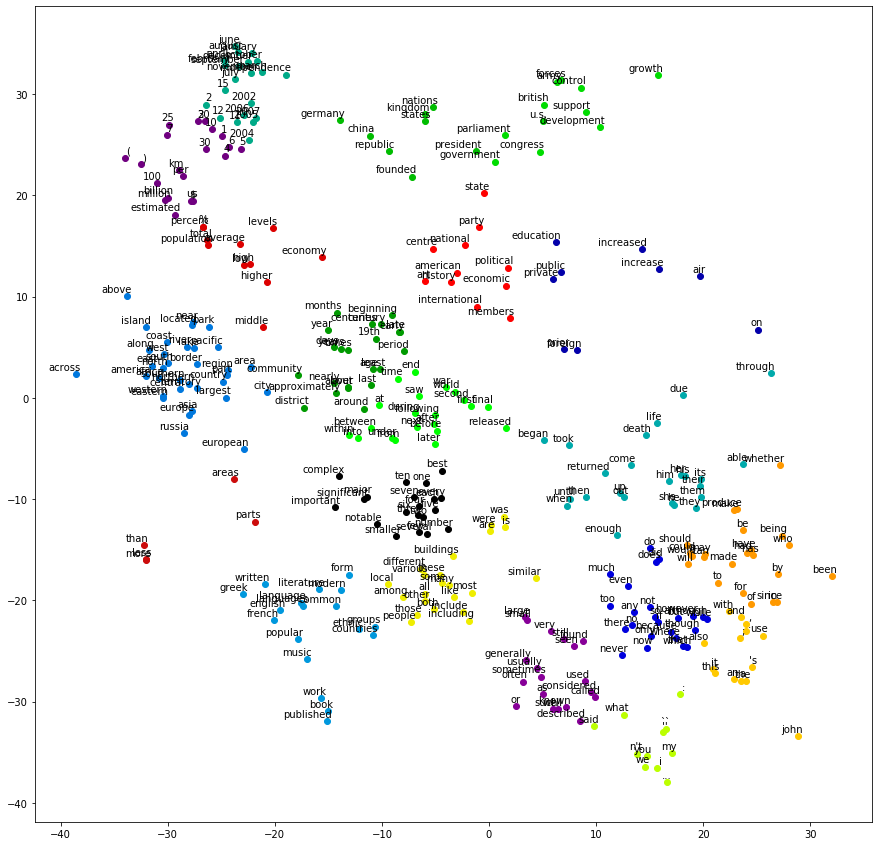

In [45]:
def plot(embeddings, labels):
  
  n_clusters = 20 # number of clusters
  # automatically build a discrete set of colors, each for cluster
  label_colors = [plt.cm.nipy_spectral(float(i) /n_clusters) for i in range(n_clusters)]
  
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
  # Define K-Means
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
  kmeans_labels = kmeans.labels_
  
  pylab.figure(figsize=(15,15))  # in inches
    
  # plot all the embeddings and their corresponding words
  for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, c=[label_colors[klabel]])    
        
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=10)

  # use for saving the figure if needed
  #pylab.savefig('word_embeddings.png')
  pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)

https://github.com/PacktPublishing/Natural-Language-Processing-with-TensorFlow/blob/master/ch3/ch3_word2vec.ipynb